In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns

In [3]:
(train_data, test_data), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.39P4IJ_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.39P4IJ_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

(train_data, test_data), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

train_data = train_data.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

In [5]:
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train, y_train = dataset_to_numpy(train_data)
X_test, y_test = dataset_to_numpy(test_data)

In [6]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [7]:
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs, centers):
        super(RBFLayer, self).__init__()
        self.num_outputs = num_outputs
        self.centers = centers

    def build(self, input_shape):
        self.betas = self.add_weight(name='betas', shape=(self.num_outputs,),
                                     initializer='ones', trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        C = tf.expand_dims(self.centers, axis=0)
        H = tf.transpose(C - tf.expand_dims(inputs, axis=1), perm=[0, 2, 1])
        return tf.exp(-self.betas * tf.reduce_sum(H**2, axis=1))

In [8]:
num_rbf = 10
kmeans = KMeans(n_clusters=num_rbf, n_init=10)
kmeans.fit(X_train)
rbf_centers = kmeans.cluster_centers_

In [17]:
model = tf.keras.Sequential([
    RBFLayer(num_rbf, rbf_centers),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.0977 - loss: 2.3038 - val_accuracy: 0.0967 - val_loss: 2.3050
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1011 - loss: 2.3041 - val_accuracy: 0.1016 - val_loss: 2.3037
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.0967 - loss: 2.3041 - val_accuracy: 0.0973 - val_loss: 2.3046
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1001 - loss: 2.3039 - val_accuracy: 0.0953 - val_loss: 2.3040
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1014 - loss: 2.3039 - val_accuracy: 0.0982 - val_loss: 2.3033
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1007 - loss: 2.3040 - val_accuracy: 0.0967 - val_loss: 2.3036
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0994 - loss: 2.3038 - val_accuracy: 0.0967 - val_loss: 2.3049
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0989 - loss:

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1616 - loss: 2.2856
Test accuracy: 0.1625


In [23]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(y_test, y_pred_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Text(95.72222222222221, 0.5, 'True')

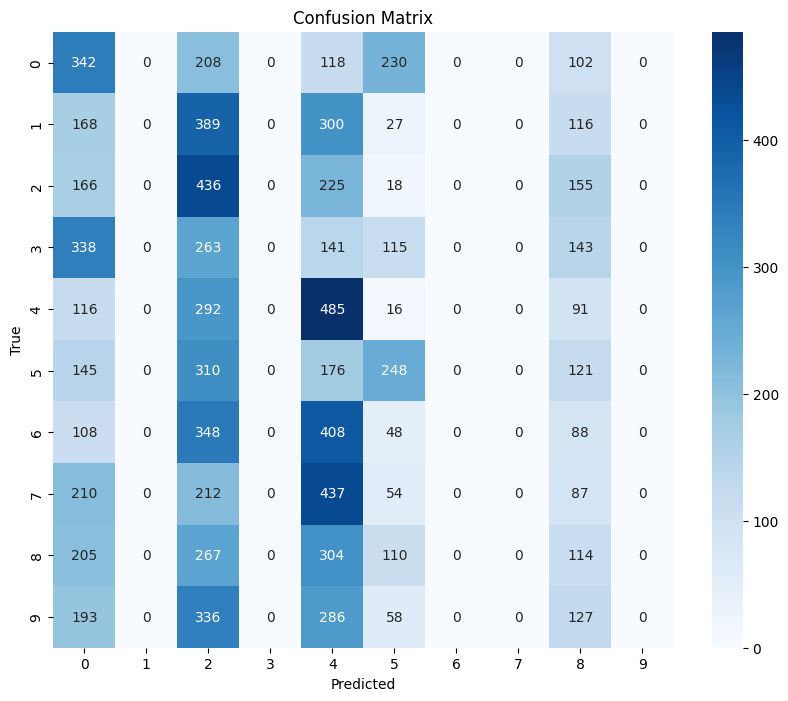

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

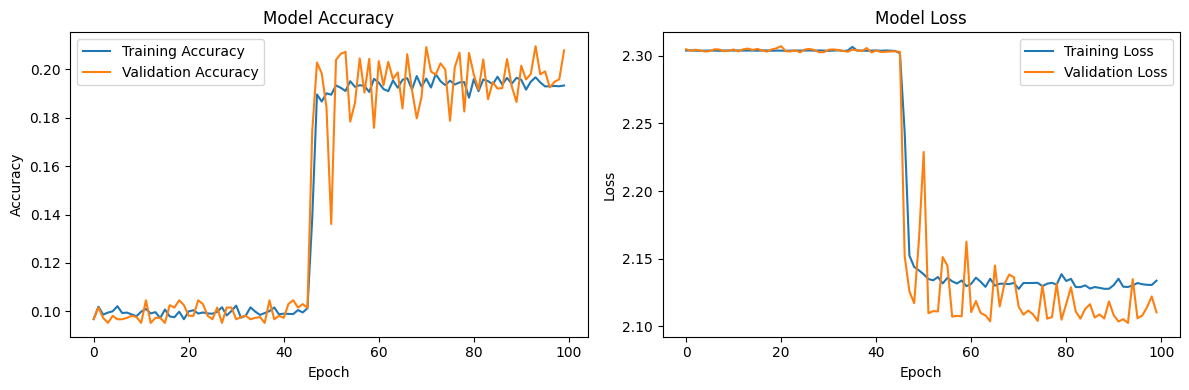

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Discuss the strengths and limitations of using an RBF network for this
dataset.**

**Strengths**

* **Non-linear Function Approximation:** RBF networks are capable of modeling complex, non-linear relationships in the data due to the Gaussian activation function, which makes them suitable for tasks like pattern recognition.

* **Local Response:** RBF neurons respond only to inputs close to their assigned centers, allowing the network to capture local patterns effectively.

* **Faster Convergence:** Training an RBF network can be faster than training a deep neural network since only the output layer weights are optimized through gradient descent, and the centers are initialized with K-means clustering.

**Limitations**

* **Scalability Issues:** RBF networks do not scale well with high-dimensional datasets or very large datasets because each RBF neuron adds computation, making the network computationally expensive with more units.

* **Center Initialization Dependence:** The performance of the RBF network is highly dependent on the quality of the centers chosen by K-means. Poor clustering can result in suboptimal performance.

* **Fixed Kernels:** The Gaussian width for the RBF units may not adapt well across all input patterns, requiring manual tuning or additional optimization.


**How does the number of RBF units affect model performance?**

**Too Few RBF Units:**

* If the number of RBF units is too small, the network may underfit the data, failing to capture the underlying patterns.
* The network might generalize poorly because it lacks enough neurons to represent all necessary regions in the input space.

**Optimal Number of RBF Units:**

* Choosing an appropriate number of RBF units helps the network strike a balance between generalization and learning capacity.
* The RBF units partition the input space effectively, and the model can learn efficiently without requiring too many parameters.

**Too Many RBF Units:**

* If the number of RBF units is too high, the network may overfit the training data, performing well on the training set but poorly on the test or validation sets.
* Excessive RBF units also increase the computational cost and memory usage, making the network slower during inference and more difficult to train.